<a href="https://colab.research.google.com/github/GR-TheArchitect/Colab_Public/blob/master/QOSF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Below is my attempt to solve tasks 2 and 4**

In [ ]:
#installing the pytket qiskit package
!pip install pytket-qiskit

In [2]:
from pytket.backends.ibm import AerStateBackend, AerBackend, AerUnitaryBackend
from pytket.backends.ibm import IBMQBackend
from qiskit import QuantumCircuit, execute, Aer
from qiskit.visualization import plot_histogram, plot_bloch_vector 
from qiskit.visualization import plot_bloch_multivector
from qiskit.quantum_info import Statevector
backend = Aer.get_backend('statevector_simulator')
backend_q = Aer.get_backend('qasm_simulator')
from collections import defaultdict

from sympy import I, Matrix, symbols
import numpy as np
from sympy.physics.quantum import TensorProduct
from math import sqrt, pi
import matplotlib.pyplot as plt

**Task #2**

In [5]:
#task 2...this gate specification is based on my own choosing
#Further down you'll fine the solution as per the guidelines in the problem

my_qc = QuantumCircuit(2)
my_qc.x(0)            # a NOT gate
my_qc.h(1)            # a Hadamard gate
my_qc.cx(1, 0)        # a C-NOT gate

my_qc.draw()

┌───┐┌───┐
q_0: ┤ X ├┤ X ├
     ├───┤└─┬─┘
q_1: ┤ H ├──■──
     └───┘

[0.        +0.j 0.70710678+0.j 0.70710678+0.j 0.        +0.j]


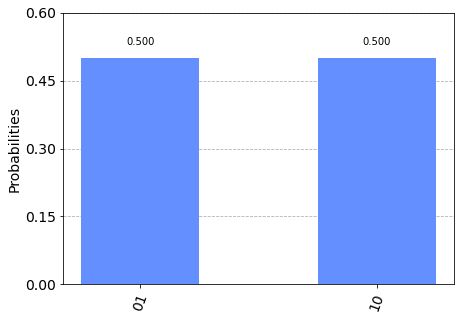

In [6]:
results = execute(my_qc, backend).result().get_statevector()
counts = execute(my_qc, backend).result().get_counts()

print(results)
plot_histogram(counts)

Statevector([0.        +0.j, 0.70710678+0.j, 0.70710678+0.j,
             0.        +0.j],
            dims=(2, 2))


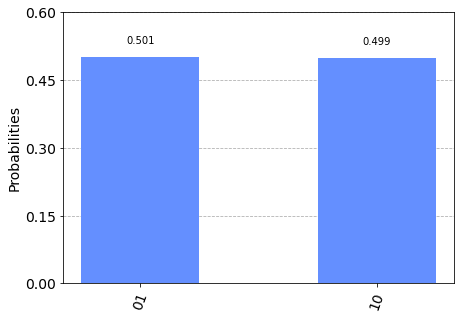

In [7]:
sv = Statevector.from_label('00') #alternative code
new_sv = sv.evolve(my_qc)
print(new_sv)

counts = new_sv.sample_counts(shots=100000)
plot_histogram(counts)

**The code below is meant to speed up the simulation of uniform variates**

In [4]:
#Generating uniform variates U[0,1] This is a 'Minimal Standard' Uniform RN generator

import random
from random import seed
from random import random

class stat_var():
  IA_1 = 16807
  IM_1 = 2147483647
  AM_1 = 1 / IM_1
  IQ_1 = 127773
  IR_1 = 2836
  Mask_1 = 123459876

def stat_ran0():
  stat_ran = 0
  NOT_FIRST_TIME = False    
  if NOT_FIRST_TIME == False:      
    stat_var.IA_1
    stat_var.IM_1
    stat_var.AM_1
    stat_var.IQ_1
    stat_var.IR_1
    stat_var.Mask_1

    Seed_1 = int(random() * stat_var.IM_1)            
    NOT_FIRST_TIME = True
    
  k = int(Seed_1 / stat_var.IQ_1)
    
  Seed_1 = stat_var.IA_1 * (Seed_1 - k * stat_var.IQ_1) - stat_var.IR_1 * k
  if Seed_1 < 0: 
    Seed_1 = Seed_1 + stat_var.IM_1

  return stat_var.AM_1 * Seed_1

#print(stat_ran0())

**Task 2: using the gates as in the problem guidelines and simulating over all angles. Two methods are implemented, a simulation method over all values of theta and a simple search to find where the angle is**

**First is the simulation over all theta values. I wasn't sure what the guidelines meant by noise. In the simulation, the noise is provided by the random uniform variate.**

In [16]:
#Compare the results for different numbers of measurements: 1, 10, 100, 1000: the code allows for
  #any number of measurements and iterations. I found that I needed at least 10000
  #iterations or so to get consistency in the results.

def qc_vqe(theta):
   
  my_circuit = QuantumCircuit(2, 2)
  my_circuit.ry(theta, 0)   #iterations over theta         
  my_circuit.cx(0, 1)            #initiates a Bell's state     
  my_circuit.rx(pi, 1)           #switches to desired state

  my_circuit.measure([0, 1], [0, 1])  #one measurement per iteration

  st_count = execute(my_circuit, backend_q, shots=1).result().get_counts()
  col_c = st_count.items()

  return st_count

n_counter = defaultdict(int)

for i in range(10000):
  n_vqe = round(stat_ran0(), 10) 
  theta_vqe = n_vqe * 2 * np.pi #round(np.random.uniform(0, 2 * np.pi), 10) 
  
  spit = qc_vqe(theta_vqe)
  
  for p, d in spit.items():
   n_counter[p] += d

print(n_counter.items())

dict_items([('10', 4944), ('01', 5056)])


**Next is a simple search for where the angle should be to get a 50/50 probability. Since the guidelines tell us what the final eigenstate should be (|0> and |1>) I didn't feel it was important to randomize both Ry and Rx. The results are presented as: angle (in term of pi), and % of simulations in each state.**

In [86]:
def qc_GD(theta):
   
  GD_circuit = QuantumCircuit(2)
  GD_circuit.ry(theta, 0)   #iterations over theta         
  GD_circuit.cx(0, 1)            #initiates a Bell's state     
  GD_circuit.rx(pi, 1)           #switches to desired state

  #GD_circuit.measure([0, 1], [0, 1])  

  #GD_count = execute(GD_circuit, backend_q, shots=1).result().get_counts()
  #col_GD = GD_count.items()

  return GD_circuit

In [104]:
def measure_zz_circuit(given_circuit):
    zz_meas = given_circuit.copy()
    zz_meas.measure_all()
    return zz_meas

In [89]:
def measure_state(given_circuit, num_shots):

    zz_meas = measure_zz_circuit(given_circuit)
    
    result = execute(zz_meas, backend = backend_q, shots = num_shots).result()
    counts = result.get_counts(zz_meas)

    if '00' not in counts:
        counts['00'] = 0
    if '01' not in counts:
        counts['01'] = 0
    if '10' not in counts:
        counts['10'] = 0
    if '11' not in counts:
        counts['11'] = 0 

    total_counts = counts['00'] + counts['11'] + counts['01'] + counts['10']
    zz = counts['00'] + counts['11'] - counts['01'] - counts['10']
    zz = zz / total_counts
    
    return counts['00']/total_counts, counts['11']/total_counts, counts['01']/total_counts, counts['10']/total_counts


**Not shown below, but the accuracy increases with the number of simulations as expected. With 10 simulations, it's hard to pinpoint the correct angle range. The range starts becoming much more visible with 1000 simulations and more. The angle is given in terms of pi (0 to 2pi) and so there are two close solutions as the angle goes through one complete cycle**

In [94]:
angle_range = np.linspace(0.0, 2.0*np.pi, 30)

for angle in angle_range:
  trial_circuit = qc_GD(angle)
  trial_results = measure_state(trial_circuit, 10000)

  print(round(angle/np.pi, 6), trial_results)

0.0 (0.0, 0.0, 0.0, 1.0)
0.068966 (0.0, 0.0, 0.0105, 0.9895)
0.137931 (0.0, 0.0, 0.0466, 0.9534)
0.206897 (0.0, 0.0, 0.0991, 0.9009)
0.275862 (0.0, 0.0, 0.1742, 0.8258)
0.344828 (0.0, 0.0, 0.2633, 0.7367)
0.413793 (0.0, 0.0, 0.3691, 0.6309)
0.482759 (0.0, 0.0, 0.4741, 0.5259)
0.551724 (0.0, 0.0, 0.5879, 0.4121)
0.62069 (0.0, 0.0, 0.6834, 0.3166)
0.689655 (0.0, 0.0, 0.778, 0.222)
0.758621 (0.0, 0.0, 0.8673, 0.1327)
0.827586 (0.0, 0.0, 0.9271, 0.0729)
0.896552 (0.0, 0.0, 0.9751, 0.0249)
0.965517 (0.0, 0.0, 0.997, 0.003)
1.034483 (0.0, 0.0, 0.9974, 0.0026)
1.103448 (0.0, 0.0, 0.9749, 0.0251)
1.172414 (0.0, 0.0, 0.9272, 0.0728)
1.241379 (0.0, 0.0, 0.8646, 0.1354)
1.310345 (0.0, 0.0, 0.7766, 0.2234)
1.37931 (0.0, 0.0, 0.6933, 0.3067)
1.448276 (0.0, 0.0, 0.578, 0.422)
1.517241 (0.0, 0.0, 0.4722, 0.5278)
1.586207 (0.0, 0.0, 0.3534, 0.6466)
1.655172 (0.0, 0.0, 0.2632, 0.7368)
1.724138 (0.0, 0.0, 0.1797, 0.8203)
1.793103 (0.0, 0.0, 0.1013, 0.8987)
1.862069 (0.0, 0.0, 0.0458, 0.9542)
1.931034 (0

**Implementing Task 4: I attempted to do this but couldn't come up with something on my own. I learned how to run vqe-like circuits during the Qiskit Summer School but couldn't come up with something different.**



In [118]:
#Task 4: 
#defining Pauli matrices

sx = np.array([[0, 1],  [ 1, 0]], dtype=np.complex128)
sy = np.array([[0, -1j],[1j, 0]], dtype=np.complex128)
sz = np.array([[1, 0],  [0, -1]], dtype=np.complex128)
id = np.array([[1, 0],  [ 0, 1]], dtype=np.complex128)

In [119]:
#decomposing the matrix [[1,0,0,0], [0,0,-1,0], [0,-1,0,0], [0,0,0,1]]
#algorithm due to Michael H. Goerz: https://michaelgoerz.net/

def HS(M1, M2):
    """Hilbert-Schmidt-Product of two matrices M1, M2"""
    return (np.dot(M1.conjugate().transpose(), M2)).trace()

def c2s(c):
    """Return a string representation of a complex number c"""
    if c == 0.0:
        return "0"
    if c.imag == 0:
        return "%g" % c.real
    elif c.real == 0:
        return "%gj" % c.imag
    else:
        return "%g+%gj" % (c.real, c.imag)

def decompose(H):
    """Decompose Hermitian 4x4 matrix H into Pauli matrices"""
    from numpy import kron
    sx = np.array([[0, 1],  [ 1, 0]], dtype=np.complex128)
    sy = np.array([[0, -1j],[1j, 0]], dtype=np.complex128)
    sz = np.array([[1, 0],  [0, -1]], dtype=np.complex128)
    id = np.array([[1, 0],  [ 0, 1]], dtype=np.complex128)
    S = [id, sx, sy, sz]
    labels = ['I', 'sigma_x', 'sigma_y', 'sigma_z']
    for i in range(4):
        for j in range(4):
            label = labels[i] + ' \ ' + labels[j]
            a_ij = 0.25 * HS(kron(S[i], S[j]), H)
            if a_ij != 0.0:
                print(c2s(a_ij), label)

H = np.array(np.array([[1,0,0,0], [0,0,-1,0], [0,-1,0,0], [0,0,0,1]]), dtype=np.complex128)
decompose(H)

0.5 I \ I
-0.5 sigma_x \ sigma_x
-0.5 sigma_y \ sigma_y
0.5 sigma_z \ sigma_z


In [120]:
#Re-constructing the matrix with the tensor product
ha = TensorProduct(id, id)*0.5 + TensorProduct(sx, sx)*-0.5 + TensorProduct(sy, sy)*-0.5 + TensorProduct(sz, sz)*0.5
print(ha)

[[ 1.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j -1.+0.j  0.+0.j]
 [ 0.+0.j -1.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  1.+0.j]]


In [125]:
TensorProduct(sy, sy)

array([[ 0.+0.j,  0.-0.j,  0.-0.j, -1.+0.j],
       [ 0.+0.j,  0.+0.j,  1.-0.j,  0.-0.j],
       [ 0.+0.j,  1.-0.j,  0.+0.j,  0.-0.j],
       [-1.+0.j,  0.+0.j,  0.+0.j,  0.+0.j]])

In [8]:
#diagonalizing the matrix and computing the eigenvalues with qiskit

from qiskit.quantum_info.operators import Operator, Pauli

h = [[0.5, Pauli(label='II')], 
     [-0.5, Pauli(label='XX')], 
     [-0.5, Pauli(label='YY')], 
     [0.5, Pauli(label='ZZ')]
    ]
H_m = []
for hi in h:
    H_m.append(hi[0]*Operator(hi[1]))
np.linalg.eigvalsh((H_m[0]+H_m[1]+H_m[2]+H_m[3]).data)


array([-1.,  1.,  1.,  1.])

In [9]:
#cross checking

from qiskit.aqua.algorithms import NumPyEigensolver
from qiskit.aqua.operators import WeightedPauliOperator

H = WeightedPauliOperator(h)
print(H.print_details())

ee = NumPyEigensolver(H)

result = ee.run()
ref = result['eigenvalues']
print(ref)

II	(0.5+0j)
XX	(-0.5+0j)
YY	(-0.5+0j)
ZZ	(0.5+0j)

[-1.-2.76098236e-17j]


In [102]:
def ansatz_circuit(angle):

  my_ansatz = QuantumCircuit(2)

  my_ansatz.h(0)
  my_ansatz.h(1)
  my_ansatz.rx(angle, 0)
  my_ansatz.rx(angle, 1)
  my_ansatz.cx(0,1)

  return my_ansatz
    
g_circuit = ansatz_circuit(np.pi)
g_circuit.draw()

┌───┐┌────────┐     
q_0: ┤ H ├┤ RX(pi) ├──■──
     ├───┤├────────┤┌─┴─┐
q_1: ┤ H ├┤ RX(pi) ├┤ X ├
     └───┘└────────┘└───┘

In [105]:
zz_meas = measure_zz_circuit(g_circuit)
zz_meas.draw()

┌───┐┌────────┐      ░ ┌─┐   
   q_0: ┤ H ├┤ RX(pi) ├──■───░─┤M├───
        ├───┤├────────┤┌─┴─┐ ░ └╥┘┌─┐
   q_1: ┤ H ├┤ RX(pi) ├┤ X ├─░──╫─┤M├
        └───┘└────────┘└───┘ ░  ║ └╥┘
meas: 2/════════════════════════╩══╩═
                                0  1

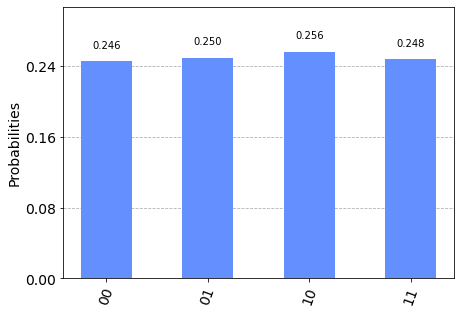

In [107]:
g_result = execute(zz_meas, backend = backend_q, shots=10000).result()
g_counts = g_result.get_counts(zz_meas)

plot_histogram(g_counts)

In [108]:
def measure_zz(given_circuit, num_shots = 10000):

    zz_meas = measure_zz_circuit(given_circuit)
    
    result = execute(zz_meas, backend = backend_q, shots = num_shots).result()
    counts = result.get_counts(zz_meas)

    if '00' not in counts:
        counts['00'] = 0
    if '01' not in counts:
        counts['01'] = 0
    if '10' not in counts:
        counts['10'] = 0
    if '11' not in counts:
        counts['11'] = 0 

    total_counts = counts['00'] + counts['11'] + counts['01'] + counts['10']
    zz = counts['00'] + counts['11'] - counts['01'] - counts['10']
    zz = zz / total_counts
    
    return zz

In [109]:
zz = measure_zz(g_circuit)
print("<ZZ> =", str(zz))

<ZZ> = 0.0198


In [110]:
def measure_xx_circuit(given_circuit):
    xx_meas = given_circuit.copy()
    
    xx_meas.h(0)
    xx_meas.h(1)
    xx_meas.measure_all()

    return xx_meas

In [111]:
xx_meas = measure_xx_circuit(g_circuit)
xx_meas.draw()

┌───┐┌────────┐     ┌───┐ ░ ┌─┐   
   q_0: ┤ H ├┤ RX(pi) ├──■──┤ H ├─░─┤M├───
        ├───┤├────────┤┌─┴─┐├───┤ ░ └╥┘┌─┐
   q_1: ┤ H ├┤ RX(pi) ├┤ X ├┤ H ├─░──╫─┤M├
        └───┘└────────┘└───┘└───┘ ░  ║ └╥┘
meas: 2/═════════════════════════════╩══╩═
                                     0  1

In [113]:
def measure_xx(given_circuit, num_shots = 10000):
    
    xx_meas = measure_xx_circuit(given_circuit)
    
    result = execute(xx_meas, backend = backend_q, shots = num_shots).result()
    counts = result.get_counts(xx_meas)

    if '00' not in counts:
        counts['00'] = 0
    if '01' not in counts:
        counts['01'] = 0
    if '10' not in counts:
        counts['10'] = 0
    if '11' not in counts:
        counts['11'] = 0

    total_counts = counts['00'] + counts['11'] + counts['01'] + counts['10']
    xx = counts['00'] + counts['11'] - counts['01'] - counts['10']
    xx = xx / total_counts
    
    return xx

xx = measure_xx(g_circuit)
print("<XX> =", str(xx))

<XX> = 1.0


In [115]:
def measure_yy_circuit(given_circuit):
    yy_meas = given_circuit.copy()
    
    yy_meas.h(0)
    yy_meas.h(1)
    yy_meas.s(0)
    yy_meas.s(1)
    
    yy_meas.measure_all()

    return yy_meas

In [116]:
yy_meas = measure_yy_circuit(g_circuit)
yy_meas.draw()

┌───┐┌────────┐     ┌───┐┌───┐ ░ ┌─┐   
   q_0: ┤ H ├┤ RX(pi) ├──■──┤ H ├┤ S ├─░─┤M├───
        ├───┤├────────┤┌─┴─┐├───┤├───┤ ░ └╥┘┌─┐
   q_1: ┤ H ├┤ RX(pi) ├┤ X ├┤ H ├┤ S ├─░──╫─┤M├
        └───┘└────────┘└───┘└───┘└───┘ ░  ║ └╥┘
meas: 2/══════════════════════════════════╩══╩═
                                          0  1

In [134]:
def measure_yy(given_circuit, num_shots = 10000):
    
    yy_meas = measure_yy_circuit(given_circuit)
    
    result = execute(yy_meas, backend = backend_q, shots = num_shots).result()
    counts = result.get_counts(yy_meas)

    if '00' not in counts:
        counts['00'] = 0
    if '01' not in counts:
        counts['01'] = 0
    if '10' not in counts:
        counts['10'] = 0
    if '11' not in counts:
        counts['11'] = 0

    total_counts = counts['00'] + counts['11'] + counts['01'] + counts['10']
    yy = counts['00'] + counts['11'] - counts['01'] - counts['10']
    
    yy = yy / total_counts
    
    return yy

yy = measure_yy(g_circuit)
print("<YY> =", str(yy))

<YY> = 1.0


In [135]:
def get_energy(given_circuit, num_shots = 10000):
    
    zz = measure_zz(given_circuit, num_shots = num_shots)
    xx = measure_xx(given_circuit, num_shots = num_shots)
    yy = measure_yy(given_circuit, num_shots = num_shots)
    
    energy = (0.5)*1 + (-0.5)*xx + (-0.5)*yy + (0.5)*zz
    
    return energy

In [136]:
energy = get_energy(g_circuit)
print("The energy of the trial state is", str(energy))

The energy of the trial state is -0.4939
